<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Tiny-imagenet/resized/15*15/tinyimagenet_15_15_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/tiny-imagenet.zip -d tiny-imagenet

In [6]:
ITERATION = 1
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 64
NUM_CLASSES = 200
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 64
TRAIN_DIR = "tiny-imagenet/tiny-imagenet/train/"
TEST_DIR = "tiny-imagenet/tiny-imagenet/test/"

In [7]:
filenames = os.listdir(TRAIN_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

filenames = os.listdir(TEST_DIR)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

validate_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [8]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

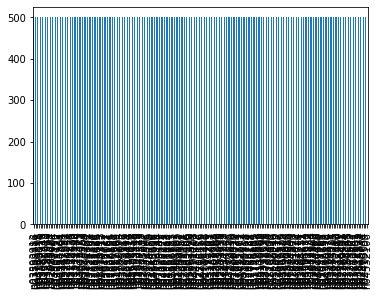

In [9]:
train_df['category'].value_counts().plot.bar()

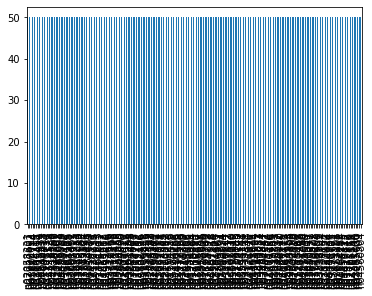

In [10]:
validate_df['category'].value_counts().plot.bar()

In [11]:
from tensorflow.image import random_flip_left_right, random_crop, random_saturation
def preprocess(image):
  image = np.array(image)
  image = random_flip_left_right(image)
  image = random_saturation(image, 0.5, 2.0)
  return image


train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    preprocessing_function=preprocess,
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAIN_DIR, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 100000 validated image filenames belonging to 200 classes.


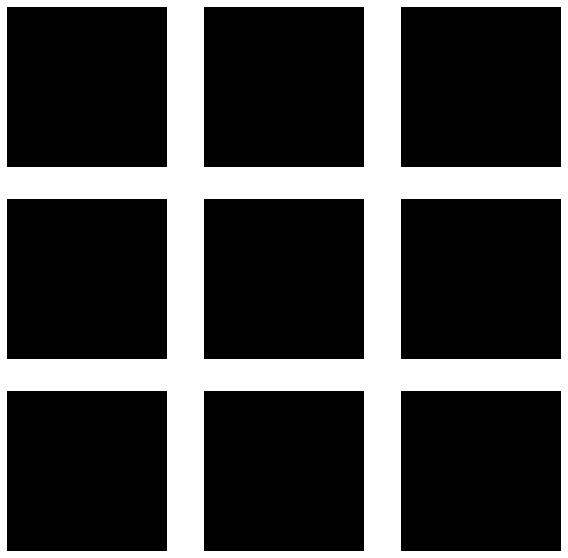

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
x,y = train_generator.next()

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x[i].astype("uint8"))
  plt.axis("off")

In [13]:
validation_datagen = ImageDataGenerator(
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TEST_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 10000 validated image filenames belonging to 200 classes.


In [14]:
print(train_df.shape)
print(validate_df.shape)

(100000, 2)
(10000, 2)


In [15]:
train_generator.image_shape

(64, 64, 3)

In [16]:
NUM_CLASSES = len(train_df['category'].value_counts())
print(NUM_CLASSES)

200


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GaborLayer (Conv2D)          (None, 64, 64, 64)        43264     
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

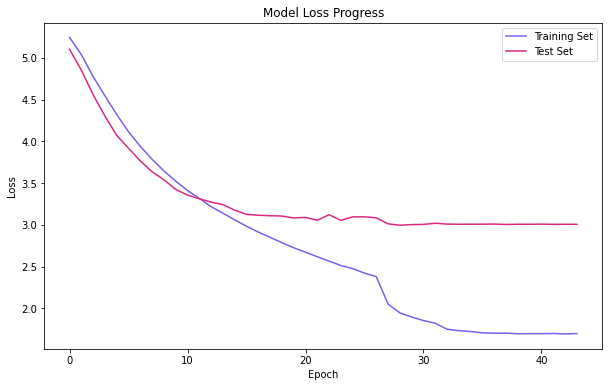

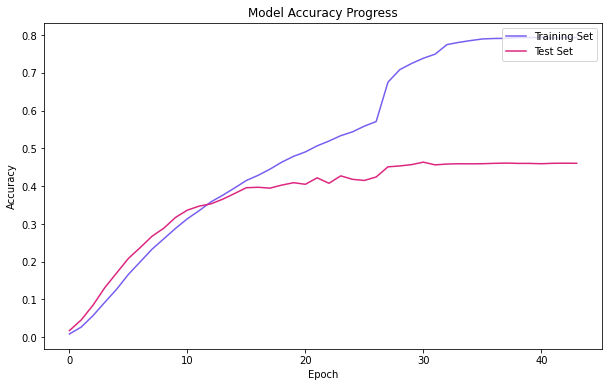

In [17]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# with width, height and preprocessing
classifier = None
classifier = Sequential([
    layers.Conv2D(64, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', activation='relu',  name="GaborLayer", input_shape=train_generator.image_shape),
    layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

import copy
untrained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/5, patience=3,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=15, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

classifier.compile(loss=CategoricalCrossentropy(label_smoothing=0.1), optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
# plt.savefig('stanfordcars-{}-loss-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
# plt.savefig('stanfordcars-{}-accuracy-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GaborLayer (Conv2D)          (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       2

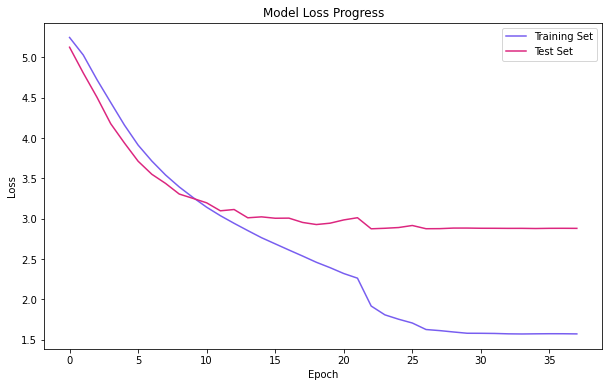

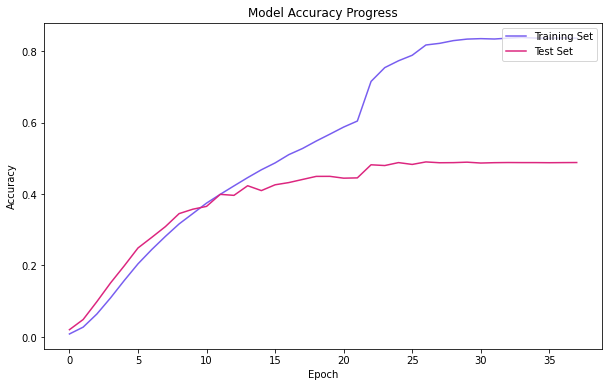

In [ ]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# with width, height and preprocessing
classifier = None
classifier = Sequential([
    layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',  name="GaborLayer", input_shape=train_generator.image_shape),
    layers.Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.Conv2D(512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(2048, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

import copy
untrained_layers = copy.deepcopy(classifier.get_layer(name=classifier.layers[GABOR_LAYER_INDEX].name).get_weights())

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/5, patience=3,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=15, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

classifier.compile(loss=CategoricalCrossentropy(label_smoothing=0.1), optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
# plt.savefig('stanfordcars-{}-loss-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
# plt.savefig('stanfordcars-{}-accuracy-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()
